## Import Req'd Libraries

In [1]:
import pandas as pd
import os
import seaborn as sns

## Functions for Getting File Names & Saving csv

In [2]:
#Getting all the file_names in a given directory
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)

#Saving the file
def save_file(root, name_of_file, my_dataframe):
    #Test if save directory exists
    try:
        my_dataframe.to_csv(root+'processed_data/'+ name_of_file, index=False)
    #Otherwise make the directory and then save
    except:
        os.mkdir(root+'processed_data')
        my_dataframe.to_csv(root+'processed_data/'+ name_of_file, index=False)


## Function for Initialization of File

In [3]:
def initialization(filepath):
    df = pd.read_csv(filepath, 
                     usecols = ['id','last_scraped', 'host_is_superhost', 
                            'latitude','longitude', 'property_type',
                           'room_type','accommodates','bathrooms',
                           'bedrooms','beds','amenities', 'price',
                            'instant_bookable','cancellation_policy'])
    df["last_scraped"] = pd.to_datetime(df["last_scraped"])
    df["price"] = df["price"].apply(lambda x: x.replace('$','').replace(',', '').replace('.00', '')).astype("int")
    return df

## Functions for Removing Missing Data and Outliers

In [4]:
#Function to remove missing data
def missing_data(my_dataframe):
    #computing number of total rows
    total_rows = my_dataframe.shape[0]
    #Dropping rows if empty cells are present in any of the given rows
    my_dataframe = my_dataframe.dropna(subset = ['id','last_scraped', 'host_is_superhost', 
                            'latitude','longitude', 'property_type',
                           'room_type','accommodates','bathrooms',
                           'bedrooms','beds','amenities', 'price',
                            'instant_bookable','cancellation_policy'])
    #Computing number of rows left after removing rows for error checking
    total_rows_after = my_dataframe.shape[0]
    
    #Printing
    print('total rows before missing data removal:', total_rows)
    print('total rows after missing data removal:', total_rows_after)
    
    return my_dataframe


def remove_outlier(my_dataframe):
    
    #Plotting a box and whisker plot for data visualization
    #sns.boxplot(x=my_dataframe['price'])
    #Computing the quantiles of the box and whisker plot
    quantiles = my_dataframe['price'].quantile([0.0001, 0.01,0.05, 0.25,0.5,0.75,0.90, 0.95,0.99])
    
    #computing number of total rows prior to removing outliers
    total_rows = my_dataframe.shape[0]
    print('Number of rows before outlier removal',total_rows)
    
    #Adjusting data based on quantile information
    my_new_dataframe = my_dataframe[(my_dataframe['price'] < quantiles.loc[0.95]) & (my_dataframe['price'] > quantiles.loc[0.05])]
    quantiles = my_new_dataframe['price'].quantile([0.0001, 0.01,0.05, 0.25,0.5,0.75,0.90, 0.95,0.99])
    sns.boxplot(x=my_new_dataframe['price'])
    
    #computing new number of total rows
    total_rows = my_new_dataframe.shape[0]
    
    print('Number of rows after outlier removal',total_rows)

    return my_new_dataframe

#Function for normalizing data 
def nomarlize_price(my_dataframe):
    my_dataframe['price'] = (my_dataframe['price'] - 
                             my_dataframe['price'].min())/(my_dataframe['price'].max() - 
                                                         my_dataframe['price'].min())
    return my_dataframe

## Functions for Mapping Categorical Data

In [5]:
# Map neighbourhood names to modified MLS district codes
def map_neighbourhoods(data, n_data):
    
    district = dict(zip(n_data["neighbourhood"].tolist(), n_data["district"].tolist()))
    district_group = dict(zip(n_data["neighbourhood"].tolist(), n_data["district_group"].tolist()))
    district_number = dict(zip(n_data["neighbourhood"].tolist(), n_data["district_number"].tolist()))

    
    data["district_group"] = data["neighbourhood_cleansed"].map(district_group)
    data["district_number"] = data["neighbourhood_cleansed"].map(district_number)
    data["district"] = data["district_group"]*15+data["district_number"]
    return data

# Convert categorical data (e.g. host_is_superhost) into numerical codes
def cat_to_code(data, root, categories):
    category_codes = {}
    
    for i in categories:
        name = data[i].name
        category_codes[name] = data[i].astype("category").cat.categories # save list of categories
        data[name+"_codes"] = data[i].astype("category").cat.codes # convert to code
    
    for i in category_codes:
        df = pd.DataFrame()
        df[i] = category_codes[i]
        df.to_csv(root+r"category_codes/"+i+".csv")
    
    return data

# Filter out categories with a small percentage (<5% of data)
def filter_categorical(data, properties, can_policy):
    num_samples = data.shape[0]
    data = data[data.property_type.isin(properties)]
    num_samples2 = data.shape[0]
    data = data[data.cancellation_policy.isin(can_policy)]
    num_samples3 = data.shape[0]
    removed = {"properties": num_samples-num_samples2,
               "can_policy": num_samples2-num_samples3}
    print("Number removed:")
    print(removed)
    return data


## Function for Filtering of Amenities

In [6]:
def amenityRemoval(df, toKeep):
    toKeep = ['TV', 'Internet', 'Wifi', 'Air conditioning', 'Kitchen', 'Indoor fireplace', 'Heating', 
          'Family/kid friendly', 'Washer', 'Dryer', 'Smoke detector', 'First aid kit', 'Fire extinguisher', 
          'Essentials', 'Shampoo', 'Cable TV', 'Pool', 'Free parking on premises', 'Doorman', 'Gym', 'Elevator', 
          'Buzzer/wireless intercom', 'Free street parking', 'Carbon monoxide detector', 'Lock on bedroom door', 
          '24-hour check-in', 'Hangers', 'Hair dryer', 'Iron', 'Laptop friendly workspace',  
          'Self check-in', 'Keypad', 'Private entrance', 'Hot water', 'Bed linens', 'Extra pillows and blankets', 
          'Microwave', 'Coffee maker', 'Refrigerator', 'Dishes and silverware', 'Cooking basics', 'Oven', 'Stove', 
          'Long term stays allowed', 'No stairs or steps to enter', 'Wheelchair accessible', 'Pets allowed', 
          'Dishwasher', 'Single level home', 'Patio or balcony', 'Luggage dropoff allowed', 
          'Paid parking on premises', 'Host greets you', 'Lockbox', 'Garden or backyard', 
          'Paid parking off premises', 'Private living room', 'Breakfast', 'Hot tub', 
          'Wide hallways', 'Safety card', 'Bathtub', 'BBQ grill', 'Room-darkening shades', 
          'Well-lit path to entrance', 'Lake access', 'Ethernet connection', 'Wide entrance for guests', 
          'Flat path to guest entrance', 'Extra space around bed', 'Wide entrance']
    amen = []
    
    for p in range(len(df)):
        amen = df["amenities"][p]
        amen = amen[1:len(amen)-1]
        amen = str(amen)
        amen = amen.replace("\"", "")
        amen = amen.split(",")

    for i in amen:
        if i not in toKeep:
            amen.remove(i)   

    for j in toKeep:
        df["amenities_"+j] = df["amenities"].apply(lambda x: j in x).astype(int)
    
    df = df.drop(columns="amenities")
    
    return df

Processing:  19_08_08_listings.csv
--Start # of Samples: 21617
total rows before missing data removal: 21617
total rows after missing data removal: 21580
Number of rows before outlier removal 21580
Number of rows after outlier removal 19247
--End # of Samples: 19247
--Total # of Samples Removed 2370
--Accumulated # of Samples: 19247
Processing:  19_07_08_listings.csv
--Start # of Samples: 21312
total rows before missing data removal: 21312
total rows after missing data removal: 21265
Number of rows before outlier removal 21265
Number of rows after outlier removal 18954
--End # of Samples: 18954
--Total # of Samples Removed 2358
--Accumulated # of Samples: 38201
Processing:  19_06_04_listings.csv
--Start # of Samples: 20769
total rows before missing data removal: 20769
total rows after missing data removal: 20724
Number of rows before outlier removal 20724
Number of rows after outlier removal 18429
--End # of Samples: 18429
--Total # of Samples Removed 2340
--Accumulated # of Samples: 5

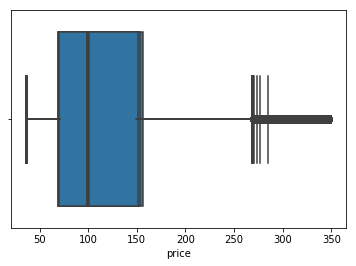

In [7]:
# get list of filenames
root = '../'

# Categories to convert to code
categories = ["host_is_superhost", "property_type", "room_type", "instant_bookable", "cancellation_policy"]

#Properties and cancellation policies to filter
properties = ["Apartment", "Condominium", "House", "Townhouse", "Guest suite", "Bungalow"]
can_policy = ["flexible", "moderate", "strict_14_with_grace_period"]

#mapping for neighbourhoods
n_data = pd.read_csv(root+'category_codes/neighbourhoods.csv')

#List of Amenities to Keep -> has more than 5%
amenToKeep = ['TV', 'Internet', 'Wifi', 'Air conditioning', 'Kitchen', 'Indoor fireplace', 'Heating', 
          'Family/kid friendly', 'Washer', 'Dryer', 'Smoke detector', 'First aid kit', 'Fire extinguisher', 
          'Essentials', 'Shampoo', 'Cable TV', 'Pool', 'Free parking on premises', 'Doorman', 'Gym', 'Elevator', 
          'Buzzer/wireless intercom', 'Free street parking', 'Carbon monoxide detector', 'Lock on bedroom door', 
          '24-hour check-in', 'Hangers', 'Hair dryer', 'Iron', 'Laptop friendly workspace',  
          'Self check-in', 'Keypad', 'Private entrance', 'Hot water', 'Bed linens', 'Extra pillows and blankets', 
          'Microwave', 'Coffee maker', 'Refrigerator', 'Dishes and silverware', 'Cooking basics', 'Oven', 'Stove', 
          'Long term stays allowed', 'No stairs or steps to enter', 'Wheelchair accessible', 'Pets allowed', 
          'Dishwasher', 'Single level home', 'Patio or balcony', 'Luggage dropoff allowed', 
          'Paid parking on premises', 'Host greets you', 'Lockbox', 'Garden or backyard', 
          'Paid parking off premises', 'Private living room', 'Breakfast', 'Hot tub', 
          'Wide hallways', 'Safety card', 'Bathtub', 'BBQ grill', 'Room-darkening shades', 
          'Well-lit path to entrance', 'Lake access', 'Ethernet connection', 'Wide entrance for guests', 
          'Flat path to guest entrance', 'Extra space around bed', 'Wide entrance']

#obtain list of files
name = get_file_names(root+'original_dataset')
accum_kept = 0
accum_removed = 0
for i in name:
    print("Processing: ", i)
    filepath = root+'original_dataset/'+i
    df = initialization(filepath)
    start_len = len(df)
    print("--Start # of Samples:", start_len)
    
    df = missing_data(df)
    df = remove_outlier(df)
    df = df.reset_index(drop=True)
    df = amenityRemoval(df, amenToKeep)
    #df = df.drop("amenities")
    df = pd.get_dummies(df)
    #df = nomarlize_price(df)
    #df = map_neighbourhoods(df, n_data)
    #df = cat_to_code(df, root, categories)
    #df = filter_categorical(df, properties, can_policy)
    end_len = len(df)
    print("--End # of Samples:", end_len)
    print("--Total # of Samples Removed", start_len-end_len)
    save_file(root, i, df)
    accum_kept += end_len
    accum_removed += start_len-end_len
    print("--Accumulated # of Samples:", accum_kept)

print("===========================================")
print("Data Processing Complete")
print("--Total # of Samples Processed: ", accum_kept+accum_removed)
print("--Total # of Samples Kept: ", accum_kept, "("+str(accum_kept/(accum_kept+accum_removed)*100)+"%)")
print("--Total # of Samples Removed: ", accum_removed, "("+str(accum_removed/(accum_kept+accum_removed)*100)+"%)")
    
#save_file(name[1],df)
#df = missing_data(df)
#df = remove_outlier(df)


In [8]:
df = df.reset_index(drop=True)

In [9]:
root+"processed_data/"

'../processed_data/'

In [10]:
df.shape

(17248, 263)